In [2]:
from __future__ import print_function,division

import os
import torch
import pandas as pd
from skimage import io,transform
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,utils

# 忽略警告
import warnings

warnings.filterwarnings('ignore')

#开启交换模式
plt.ion()


In [3]:
### 下载图片数据
 
import os
import os.path
import errno
url ='https://download.pytorch.org/tutorial/faces.zip'
filename='faces.zip'
 
def download(root):
    '''
    下载数据人脸图像和标注点的压缩包。
    使用zipfile包解压。    
    '''
    root = os.path.expanduser(root)
    import zipfile
    
    #下载图片压缩包到指定路径
    download_url(url,root,filename)
    
    print("数据下载完毕！")
    #获得当前路径
    cwd = os.getcwd()    
    path = os.path.join(root, filename)
    tar = zipfile.ZipFile(path, "r")
    #解压文件
    tar.extractall(root)
    tar.close()
    #切换到当前工作路径
    os.chdir(cwd)
 
def download_url(url, root, filename):
    from six.moves import urllib
    root = os.path.expanduser(root)
    fpath = os.path.join(root, filename)
    
    try:
        os.makedirs(root)
    except OSError as e:
        if e.errno == errno.EEXIST:
            pass
        else:
            raise
    
    # downloads file
    if os.path.isfile(fpath) :
        print('使用已下载文件: ' + fpath)
    else:
        try:
            print('下载 ' + url + ' 到 ' + fpath)
            urllib.request.urlretrieve(url, fpath)
        except:
            if url[:5] == 'https':
                url = url.replace('https:', 'http:')
                print('下载失败。 尝试将https -> http'
                      ' 下载  ' + url + ' 到 ' + fpath)
                urllib.request.urlretrieve(url, fpath)
 
download('./')


下载 https://download.pytorch.org/tutorial/faces.zip 到 ./faces.zip
数据下载完毕！


In [4]:
landmarks_frame = pd.read_csv('faces/face_landmarks.csv')
landmarks_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Columns: 137 entries, image_name to part_67_y
dtypes: int64(136), object(1)
memory usage: 74.0+ KB


In [5]:
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [8]:
n = 3
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].values
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

Image name: 110276240_bec305da91.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 42. 140.]
 [ 45. 161.]
 [ 51. 180.]
 [ 61. 200.]]


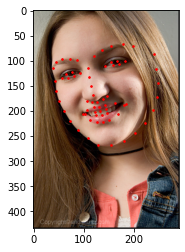

In [9]:
def show_landmarks(image, landmarks):
    """显示带标记点的图片"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # 暂停一下, 使plots更新

plt.figure()
show_landmarks(io.imread(os.path.join('faces/', img_name)),
               landmarks)
plt.show()

In [10]:
class FaceLandmarksDataset(Dataset):
    ''' Face Landmarks Dataset '''
    def __init__(self,csv_file,root_dir,transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self,idx):
        #获得指定索引图片的路径
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx,0])
        #读取图片数据
        image = io.imread(img_name)
        #将标注点数据转换成矩阵（行向量）
        landmarks = self.landmarks_frame.iloc[idx,1:].as_matrix()
        #将矩阵转换成N行2列的矩阵。
        landmarks = landmarks.astype('float').reshape(-1,2)
        
        sample = {'image':image,'landmarks':landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample